In [3]:
import mysql.connector

# Stabilire la connessione
conn = mysql.connector.connect(
    host="localhost",    
    user="root",         
    password="",         
    database="classicmodels"
)

cursor = conn.cursor()

# Verificare la connessione
cursor.execute("SELECT DATABASE()")
result = cursor.fetchone()
print("Connesso al database:", result[0])

Connesso al database: classicmodels


In [15]:
import pandas as pd

# Carica i dati
df = pd.read_csv('dati_vendite.csv')

# Converti la colonna orderDate in un formato datetime
df['dataOrdine'] = pd.to_datetime(df['dataOrdine'])


In [16]:
# Imposta la colonna orderDate come indice
df.set_index('dataOrdine', inplace=True)

# Aggrega per mese
monthly_sales = df.resample('M').sum()


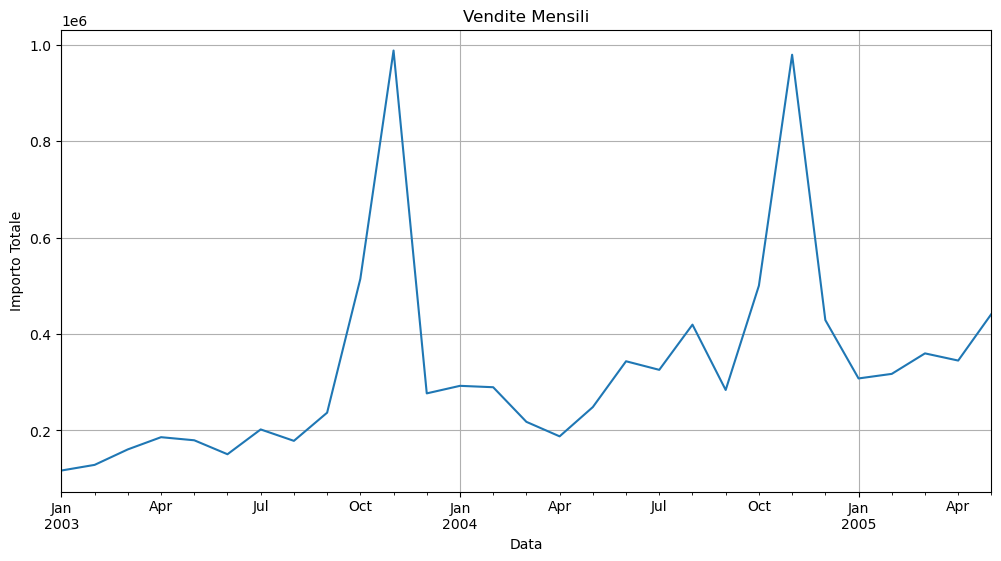

In [18]:
import matplotlib.pyplot as plt

# Visualizza le vendite mensili
plt.figure(figsize=(12,6))
monthly_sales['Totale'].plot()
plt.title('Vendite Mensili')
plt.ylabel('Importo Totale')
plt.xlabel('Data')
plt.grid(True)
plt.show()


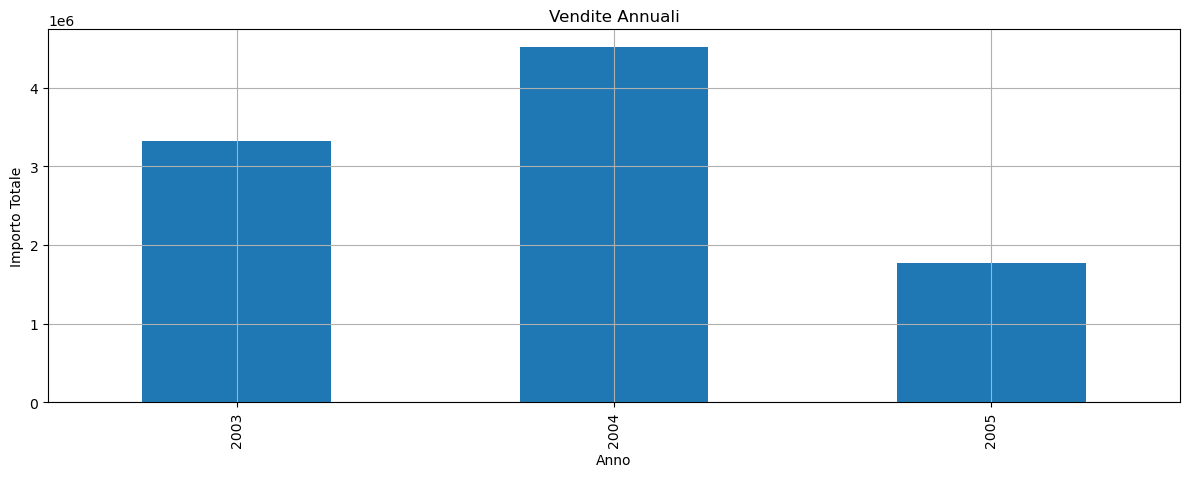

In [19]:
# Istogramma vendite annuali
annual_sales = df.resample('A').sum()
plt.figure(figsize=(12,6))
annual_sales['Totale'].plot(kind='bar')
plt.title('Vendite Annuali')
plt.ylabel('Importo Totale')
plt.xlabel('Anno')
plt.grid(True)
plt.tight_layout()

# Mostrare solo anno sull'asse x
labels = [item.strftime('%Y') for item in annual_sales.index]
plt.xticks(range(len(labels)), labels)

plt.show()

In [22]:
df = pd.read_csv('vendite_per_categoria.csv')

In [23]:
# Impostazione colonna dataOrdine come indice e converzione in formato datetime
df['dataOrdine'] = pd.to_datetime(df['dataOrdine'])
df.set_index('dataOrdine', inplace=True)

In [25]:
# Colonna = Categoria prodotto
pivot_df = df.pivot_table(values='Totale', index='dataOrdine', columns='Linea', aggfunc='sum')

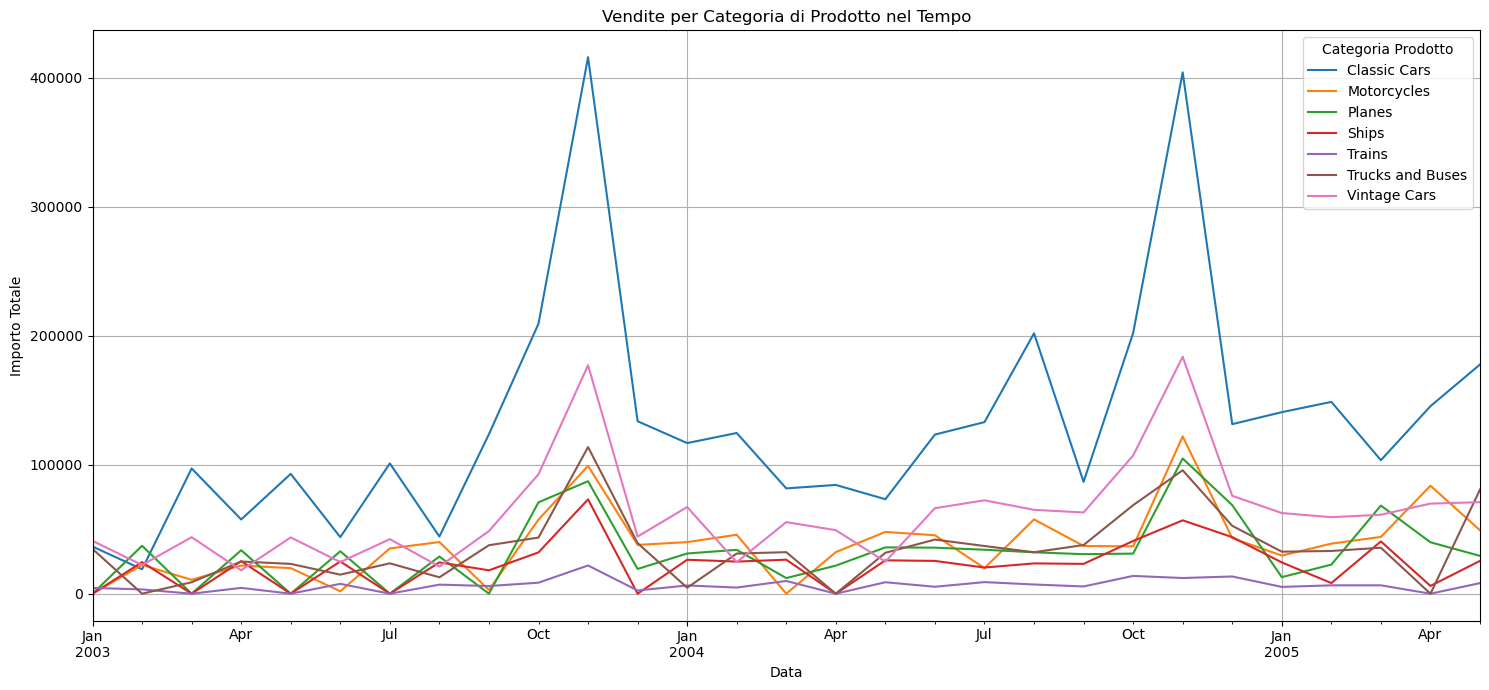

In [26]:
# Vendite su base mensile
vendita_base_mensile = pivot_df.resample('M').sum()
plt.figure(figsize=(15,7))
vendita_base_mensile.plot(ax=plt.gca())

plt.title('Vendite per Categoria di Prodotto nel Tempo')
plt.ylabel('Importo Totale')
plt.xlabel('Data')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Categoria Prodotto')
plt.show()

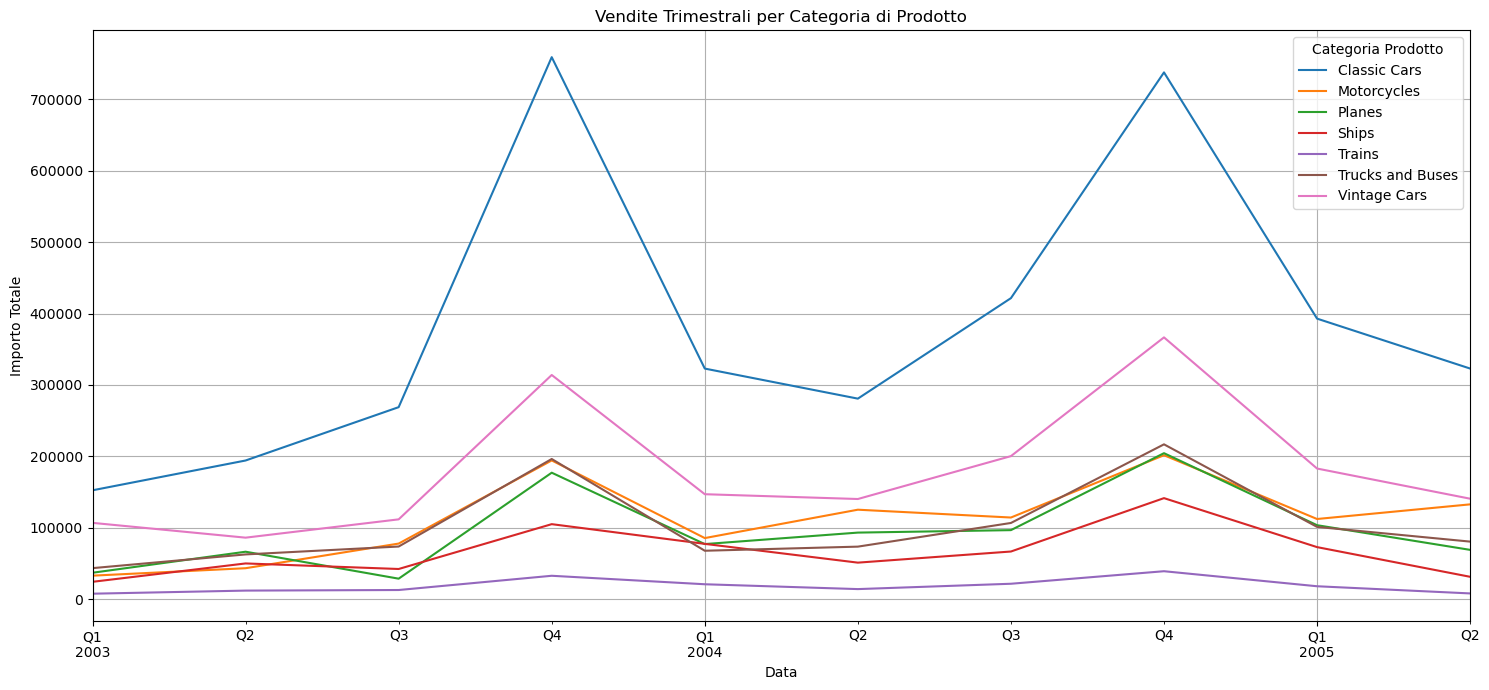

In [27]:
# Vendite su base trimestrale
vendite_trimestrali_categoria = pivot_df.resample('Q').sum()
plt.figure(figsize=(15,7))
vendite_trimestrali_categoria.plot(ax=plt.gca())
plt.title('Vendite Trimestrali per Categoria di Prodotto')
plt.ylabel('Importo Totale')
plt.xlabel('Data')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Categoria Prodotto')
plt.show()


Da qui in poi previsioni di vendita con metodo di "Holt-Winters"

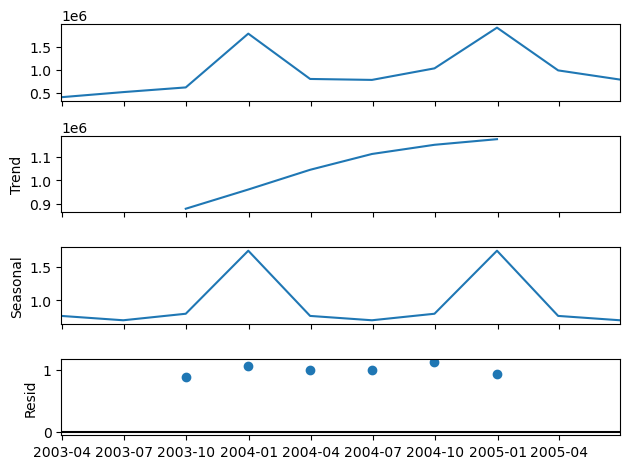

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


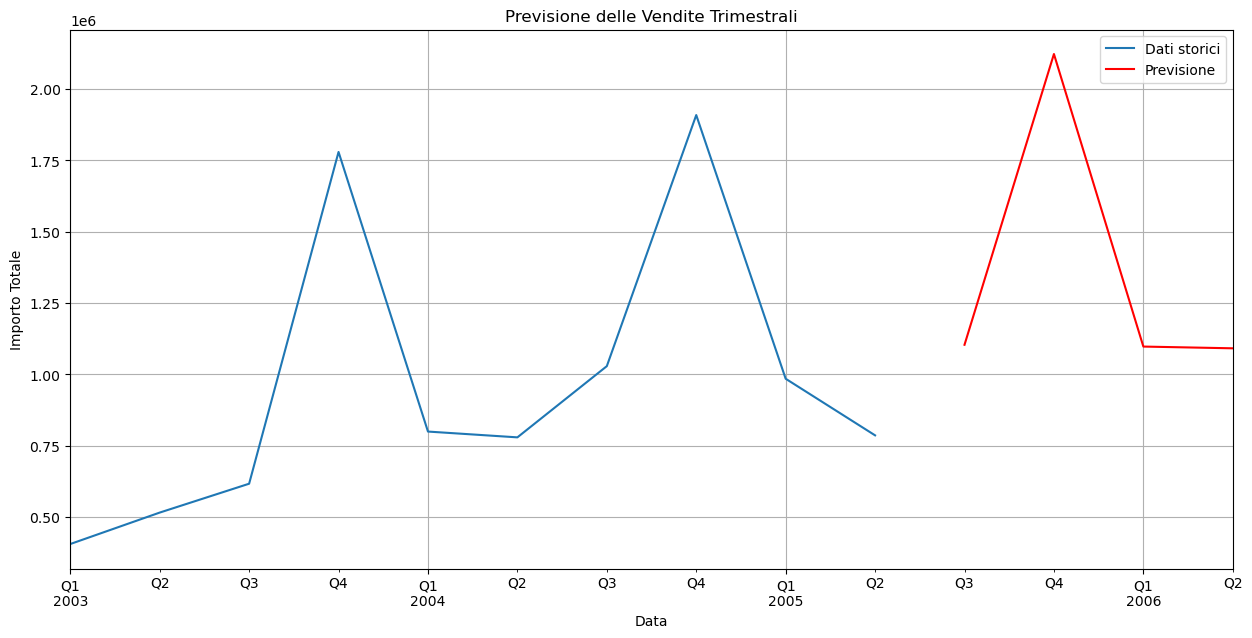

In [13]:
#Aggregazione su base trimestrale
vendite_trimestrali_totali = vendite_trimestrali_categoria.sum(axis=1)

#Decomposizione serie storica per visualizzare tendenza, stagionalità e "rumore residuo"
from statsmodels.tsa.seasonal import seasonal_decompose
risultato = seasonal_decompose(vendite_trimestrali_totali, model='multiplicative')
risultato.plot()
plt.show()

# Addestramento modello HW con i dati
from statsmodels.tsa.holtwinters import ExponentialSmoothing
modello = ExponentialSmoothing(vendite_trimestrali_totali, trend='additive', seasonal='additive', seasonal_periods=4)
addestramento = modello.fit()

# Previsioni per prossimi 4 trimestri
previsione = addestramento.forecast(steps=4)
plt.figure(figsize=(15,7))
vendite_trimestrali_totali.plot(label='Dati storici')
previsione.plot(label='Previsione', color='red')
plt.title('Previsione delle Vendite Trimestrali')
plt.ylabel('Importo Totale')
plt.xlabel('Data')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Export per PowerBi
# Pagina 4
monthly_sales.to_csv('vendite_mensili.csv')
annual_sales.to_csv('vendite_annuali.csv')
vendite_trimestrali_categoria.to_csv('vendite_trimestrali_categoria.csv')

# Combina dati storici e previsioni in un singolo dataframe
df_export = pd.concat([vendite_trimestrali_totali, previsione], axis=1)
df_export.columns = ['Dati_storici', 'Previsione']

# export
df_export.to_csv('previsioni_vendite.csv')
